
=== Rolling Day 2024-12-01 ===
  train_cutoff=2024-07-01  val_cutoff=2024-11-30
  Forecast next 30 days from 2024-12-01 w/ noise => more volatility
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-01_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-01_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-01_V1.pt
[PyTorch] Loading CNN from ./best_CNN_2024-12-01_V1.pt
[PyTorch] Loading Transformer from ./best_Transformer_2024-12-01_V1.pt
[PyTorch] Loading N-BEATS from ./best_N-BEATS_2024-12-01_V1.pt
[PyTorch] Loading N-HITS from ./best_N-HITS_2024-12-01_V1.pt
[sklearn] Loading SVM => ./best_SVM_2024-12-01_V1.pkl
[sklearn] Loading Boost => ./best_Boost_2024-12-01_V1.pkl

=== Rolling Day 2024-12-02 ===
  train_cutoff=2024-07-02  val_cutoff=2024-12-01
  Forecast next 30 days from 2024-12-02 w/ noise => more volatility
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-02_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-02_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-02_V1.pt
[PyTor

/tmp/ipykernel_808376/2902093502.py:385: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_slope= df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
/tmp/ipykernel_808376/2902093502.py:404: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_vol= df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()


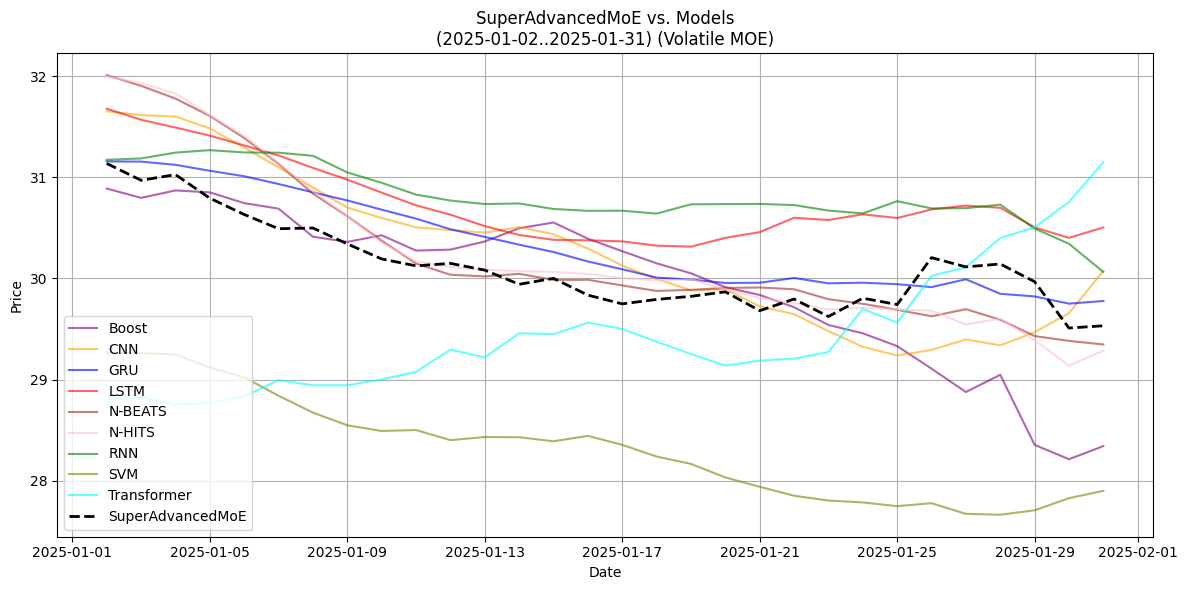

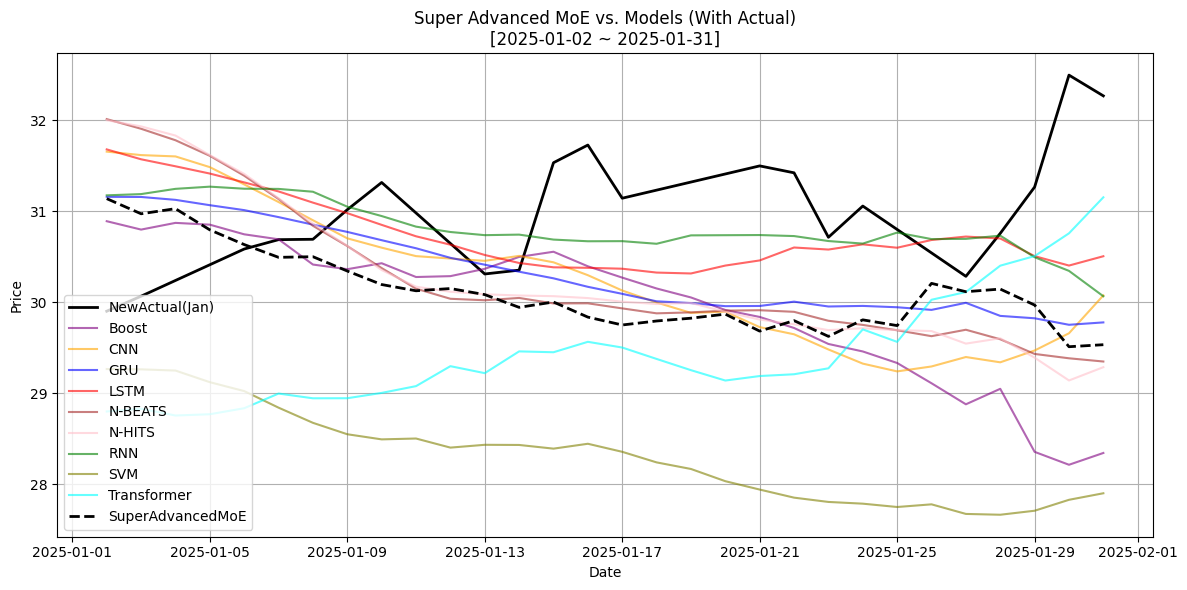

/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: 

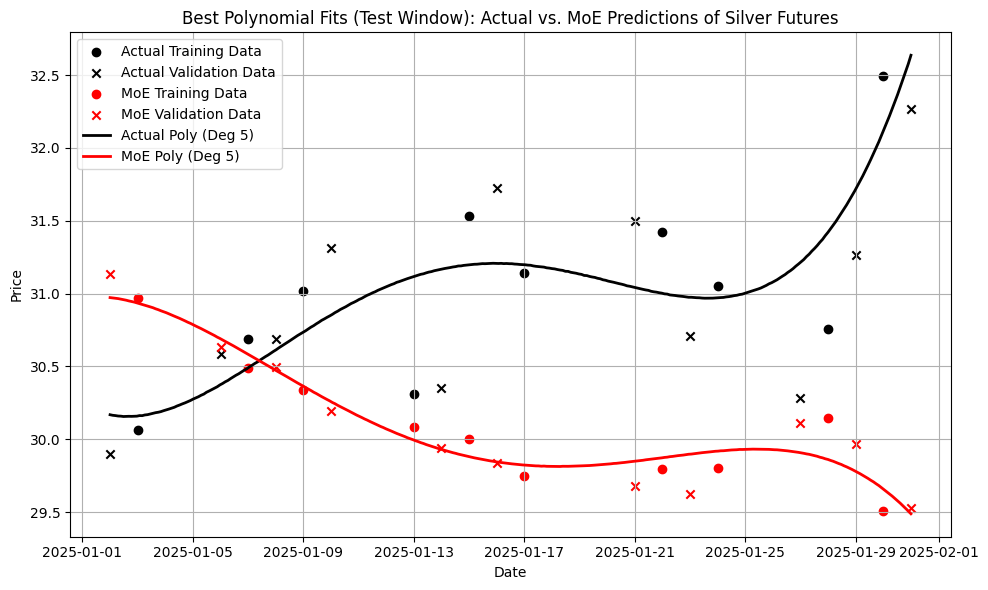


=== Best Polynomial Fitting Results ===
[Actual] => Degree=5, Val MSE=0.250633
     y = 1.1582e-09*x^5-6.9896e-05*x^4+9.4023e-01*x^3+1.8688e+04*x^2-5.6564e+08*x+3.7931e+12

[MoE] => Degree=5, Val MSE=0.019848
     y = -5.8177e-10*x^5+3.5113e-05*x^4-4.7237e-01*x^3-9.3882e+03*x^2+2.8418e+08*x-1.9057e+12

=== Derivative for Actual (Degree 5 => 4) ===
   d/dx of Actual = 5.7908e-09*x^4-2.7959e-04*x^3+2.8207e+00*x^2+3.7377e+04*x-5.6564e+08

=== Derivative for MoE (Degree 5 => 4) ===
   d/dx of MoE = -2.9088e-09*x^4+1.4045e-04*x^3-1.4171e+00*x^2-1.8776e+04*x+2.8418e+08



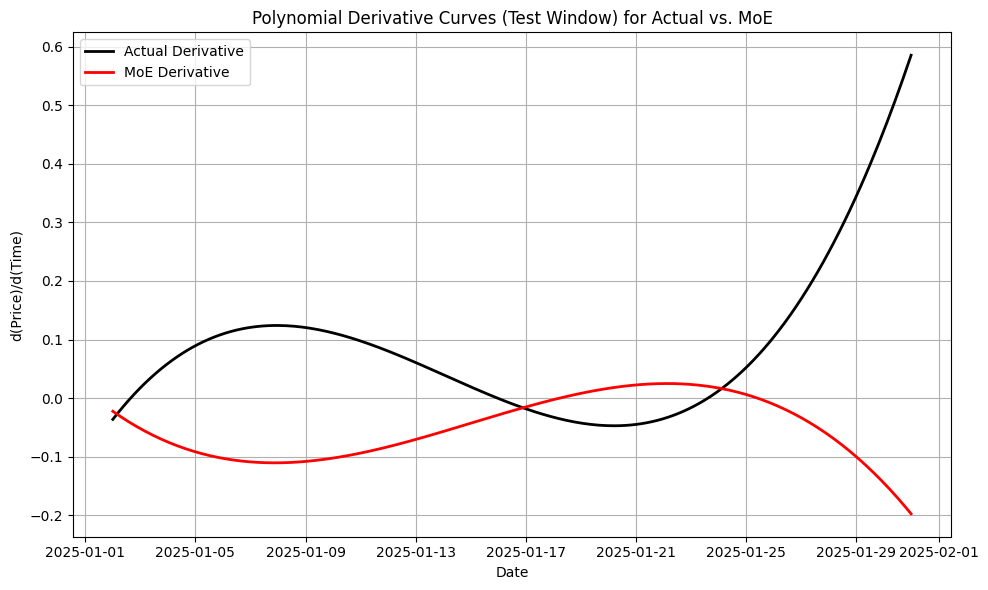


All done with MoE + polynomial fittings for both Actual and MoE!


In [4]:
####################################################
# SUPER ADVANCED MOE SCRIPT (WITH ACTUAL & POLYNOMIALS)
####################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib

from numpy.polynomial.polynomial import polyfit, polyval
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

# Global seeds & device
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BEST_MODELS_DIR = "."   # Where .pt/.pkl model files are stored
features = ["Price","Open","High","Low"]
WINDOW_SIZE = 35

############################################
# 1) Model Definitions & Loading
############################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type

        if model_type == "CNN":
            self.conv1 = nn.Conv1d(4, 64, 3)
            self.conv2 = nn.Conv1d(64, 128, 3)
            with torch.no_grad():
                dummy = torch.zeros(1, 4, window_width)
                outdummy = self.conv2(F.relu(self.conv1(dummy)))
                conv_output_size = outdummy.shape[1]*outdummy.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "GRU":
            self.rnn = nn.GRU(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "RNN":
            self.rnn = nn.RNN(4, 128, num_layers=2, nonlinearity="relu", batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.1)
            self.bn  = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.1)
            self.fc = nn.Linear(128, 4)

        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            enc_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.05)
            self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers=3)
            self.fc = nn.Linear(128,4)

        elif model_type in ["N-BEATS","N-HITS"]:
            self.input_size= window_width*4
            self.blocks= nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size,128),
                nn.ReLU(),
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,4)
            ) for _ in range(3)])
        else:
            raise ValueError(f"Invalid model_type: {model_type}")

    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0,2,1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            return self.fc(x)

        elif self.model_type in ["LSTM","GRU","RNN"]:
            out, _ = self.rnn(x)
            out = out[:,-1,:]
            return self.fc(out)

        elif self.model_type == "EnhancedLSTM":
            out, _= self.rnn(x)
            out = out[:,-1,:]
            out = self.bn(out)
            out = self.dropout(out)
            return self.fc(out)

        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1,0,2)
            x = self.transformer_encoder(x)
            x = x[-1,:,:]
            return self.fc(x)

        elif self.model_type in ["N-BEATS","N-HITS"]:
            xflat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast += block(xflat)
            return forecast

        else:
            raise ValueError("Invalid model_type")

class SklearnWrapper:
    def __init__(self, model):
        self.model= model
    def forward(self, x):
        arr= x.cpu().numpy().reshape(1,-1)
        pred= self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self): pass
    def __call__(self, x):
        return self.forward(x)

def load_torch_model(model_type, window_size, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[PyTorch] Loading {model_type} from {path}")
    net= BaseModel(model_type, window_size).to(device)
    net.load_state_dict(torch.load(path, map_location=device))
    net.eval()
    return net

def load_sklearn_model(model_type, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[sklearn] Loading {model_type} => {path}")
    loaded= joblib.load(path)
    return SklearnWrapper(loaded)

############################################
# 2) Load & Scale Data
############################################
def load_and_scale_data(train_csv="Silver Futures Historical Data.csv",
                        complete_csv="Silver Futures Historical Data_Complete.csv"):
    df_train = pd.read_csv(train_csv)
    df_train["Date"] = pd.to_datetime(df_train["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_train.columns:
            df_train.drop(columns=[col], errors="ignore", inplace=True)

    for feat in features:
        if feat not in df_train.columns:
            df_train[feat]= np.nan
        else:
            df_train[feat]= df_train[feat].astype(str).str.replace(",", "", regex=True)
            df_train[feat]= pd.to_numeric(df_train[feat], errors="coerce")

    df_train.sort_values("Date", inplace=True)
    df_train.reset_index(drop=True, inplace=True)

    train_cutoff= pd.to_datetime("2024-07-01")
    val_cutoff  = pd.to_datetime("2024-11-30")
    test_cutoff = pd.to_datetime("2024-12-01")

    df_trn= df_train[df_train["Date"]< train_cutoff].copy()
    df_val= df_train[(df_train["Date"]>= train_cutoff)&(df_train["Date"]<= val_cutoff)].copy()
    df_tst= df_train[df_train["Date"]>= test_cutoff].copy()

    df_trn_nonan= df_trn.dropna(subset=features)
    scaler= MinMaxScaler()
    scaler.fit(df_trn_nonan[features])

    df_trn_scaled= df_trn.copy()
    if not df_trn_nonan.empty:
        df_trn_scaled.loc[df_trn_nonan.index, features]= scaler.transform(df_trn_nonan[features])
    df_val_scaled= df_val.copy()
    val_no_nan= df_val_scaled.dropna(subset=features)
    if not val_no_nan.empty:
        df_val_scaled.loc[val_no_nan.index, features]= scaler.transform(val_no_nan[features])
    df_tst_scaled= df_tst.copy()
    trn_mins= df_trn_nonan[features].min()
    df_tst_filled= df_tst_scaled[features].fillna(trn_mins)
    df_tst_scaled.loc[:, features]= scaler.transform(df_tst_filled)

    df_scaled= pd.concat([df_trn_scaled, df_val_scaled, df_tst_scaled], ignore_index=True)

    # also load complete
    df_complete= pd.read_csv(complete_csv)
    df_complete["Date"]= pd.to_datetime(df_complete["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_complete.columns:
            df_complete.drop(columns=[col], errors="ignore", inplace=True)
    for feat in features:
        df_complete[feat]= df_complete[feat].astype(str).str.replace(",", "",regex=True).astype(float)
    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)

    return df_scaled, df_complete, scaler

############################################
# 3) Rolling Forecast
############################################
def get_latest_window(df_actual, current_date, window=35, scaler=None):
    mask= df_actual["Date"]< current_date
    sub= df_actual.loc[mask].copy()
    sub.sort_values("Date", inplace=True)
    if len(sub)< window:
        return None
    sub[features]= sub[features].fillna(method="ffill").fillna(method="bfill")
    arr= scaler.transform(sub[features].iloc[-window:].values)
    return arr

def forecast_n_days_from_date(model, df_actual, start_date, window=35, horizon=30,
                              device=None, scaler=None, noise_std=0.05):
    """
    Rolling forecast with mild random noise => more "volatility".
    """
    def add_noise_4d(prices, std=0.01):
        noise= np.random.normal(0.0, std, size=prices.shape)
        return np.clip(prices+noise, a_min=0, a_max=None)

    arr_window= get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()

    rolling_buffer= np.copy(arr_window)
    forecast_records=[]
    cur_dt= pd.to_datetime(start_date)

    for i in range(horizon):
        X_in= torch.tensor(rolling_buffer,dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            out_scaled= model(X_in).cpu().numpy()[0]
        out_unscaled= scaler.inverse_transform(out_scaled.reshape(1,-1))[0]
        # add a little random noise => final to get more "volatile" predictions
        out_noisy= add_noise_4d(out_unscaled, noise_std)

        dayx= cur_dt+ pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": out_noisy[0],
            "Pred_Open_unscaled":  out_noisy[1],
            "Pred_High_unscaled":  out_noisy[2],
            "Pred_Low_unscaled":   out_noisy[3]
        })

        out_noisy_scaled= scaler.transform(out_noisy.reshape(1,-1))[0]
        rolling_buffer= np.vstack([rolling_buffer[1:], out_noisy_scaled.reshape(1,-1)])

    return pd.DataFrame(forecast_records)

def rolling_train_validate_predict_moe(
    df_full, scaler_obj, model_types,
    start_train_cutoff=pd.to_datetime("2024-07-01"),
    start_val_cutoff=pd.to_datetime("2024-11-30"),
    start_pred=pd.to_datetime("2024-12-01"),
    end_pred=pd.to_datetime("2025-01-01"),
    horizon_days=30,
    do_daily_plots=False
):
    df_sorted= df_full.copy()
    df_sorted.sort_values("Date", inplace=True)

    date_rng= pd.date_range(start_pred, end_pred, freq="D")
    all_records=[]

    for i, day_i in enumerate(date_rng):
        train_cutoff_i= start_train_cutoff + pd.Timedelta(days=i)
        val_cutoff_i  = start_val_cutoff   + pd.Timedelta(days=i)

        print(f"\n=== Rolling Day {day_i.date()} ===")
        print(f"  train_cutoff={train_cutoff_i.date()}  val_cutoff={val_cutoff_i.date()}")
        print(f"  Forecast next {horizon_days} days from {day_i.date()} w/ noise => more volatility")

        # load each model
        model_dict={}
        for mt in model_types:
            out_file= f"best_{mt}_{day_i.strftime('%Y-%m-%d')}_V1"
            if mt in ["SVM","GPR","Boost"]:
                out_file+= ".pkl"
                net= load_sklearn_model(mt, os.path.join(BEST_MODELS_DIR, out_file))
            else:
                out_file+= ".pt"
                net= load_torch_model(mt, WINDOW_SIZE, os.path.join(BEST_MODELS_DIR, out_file))
            model_dict[mt]= net

        daily_fcst={}
        for mt, netobj in model_dict.items():
            df_fc= forecast_n_days_from_date(
                model=netobj,
                df_actual=df_sorted,
                start_date=day_i,
                window=WINDOW_SIZE,
                horizon=horizon_days,
                device=device,
                scaler=scaler_obj,
                noise_std=0.01   # control final volatility
            )
            if not df_fc.empty:
                df_fc["BaseDate"]= day_i
                df_fc["Model"]= mt
                daily_fcst[mt]= df_fc
                all_records.append(df_fc)
            else:
                daily_fcst[mt]= pd.DataFrame()

        # optional daily plots
        if do_daily_plots and (day_i== date_rng[-1]):
            pass

    df_all= pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame()
    df_all.sort_values(["Model","BaseDate","ForecastDate"], inplace=True)
    return df_all

############################################
# 4) Advanced MoE (Population Voting w/ mini-model approach)
############################################
def build_mini_models_table(final_rolling_fcst, df_actual):
    """
    For each (model, baseDate) => measure january performance => mae, slope alignment, volatility alignment
    """
    start_jan= pd.to_datetime("2024-12-01")
    end_jan=   pd.to_datetime("2025-01-01")
    df_jan= final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"]>= start_jan)&
        (final_rolling_fcst["ForecastDate"]<= end_jan)
    ].copy()
    if df_jan.empty:
        return pd.DataFrame(), 0.01

    df_act_jan= df_actual[
        (df_actual["Date"]>= start_jan)&
        (df_actual["Date"]<= end_jan)
    ].copy()
    df_act_jan.rename(columns={"Date":"ForecastDate","Price":"ActualPrice"}, inplace=True)

    df_merge= pd.merge(
        df_jan[["Model","BaseDate","ForecastDate","Pred_Price_unscaled"]],
        df_act_jan[["ForecastDate","ActualPrice"]],
        on="ForecastDate",
        how="inner"
    )
    df_merge["AbsError"]= (df_merge["Pred_Price_unscaled"]- df_merge["ActualPrice"]).abs()

    # mae
    g_mae= df_merge.groupby(["Model","BaseDate"])["AbsError"].mean().reset_index()
    g_mae.rename(columns={"AbsError":"mae_jan"}, inplace=True)

    # slope alignment => quick polynomial fit
    def poly_slope_diff(sub):
        sub= sub.sort_values("ForecastDate")
        xvals= np.arange(len(sub))
        yvals= sub["Pred_Price_unscaled"].values
        if len(yvals)< 4:
            return 0.5
        coefs= polyfit(xvals,yvals,deg=2)
        y_pred= polyval(xvals, coefs)
        resid= yvals- y_pred
        sse= np.mean(resid**2)
        return float(np.exp(-sse))

    def group_slope_func(grp):
        grp["slopeAlign_jan"]= poly_slope_diff(grp)
        return grp

    df_slope= df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
    df_slope_agg= df_slope.groupby(["Model","BaseDate"])["slopeAlign_jan"].mean().reset_index()

    # real vol
    df_act_jan_sorted= df_act_jan.drop_duplicates("ForecastDate").copy()
    df_act_jan_sorted.sort_values("ForecastDate", inplace=True)
    df_act_jan_sorted["DayChange"]= df_act_jan_sorted["ActualPrice"].diff()
    real_vol= df_act_jan_sorted["DayChange"].std(skipna=True)
    if pd.isna(real_vol) or real_vol< 1e-9:
        real_vol= 0.01

    # pred vol => stdev of dayChange
    def mini_volatility(sub):
        sub= sub.sort_values("ForecastDate")
        sub["DayChange"]= sub["Pred_Price_unscaled"].diff()
        vol_= sub["DayChange"].std(skipna=True)
        if pd.isna(vol_): vol_= 0.01
        return vol_

    g_vol= df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()
    g_vol.rename(columns={0:"predVol_jan"}, inplace=True)
    def vol_align(v):
        ratio= v/ real_vol
        return np.exp(-abs(ratio-1.0))
    g_vol["volAlign_jan"]= g_vol["predVol_jan"].apply(vol_align)

    mini_models= pd.merge(g_mae, df_slope_agg, on=["Model","BaseDate"], how="left")
    mini_models= pd.merge(mini_models, g_vol[["Model","BaseDate","predVol_jan","volAlign_jan"]], on=["Model","BaseDate"], how="left")

    mae_min= mini_models["mae_jan"].min()
    mae_max= mini_models["mae_jan"].max()
    if np.isclose(mae_min, mae_max):
        mini_models["baseAcc"]= 1.0
    else:
        mini_models["baseAcc"]= 1.0- ((mini_models["mae_jan"]-mae_min)/(mae_max-mae_min))

    return mini_models, real_vol

def compute_super_advanced_moe(final_rolling_fcst, df_actual):
    """
    1) Build "mini-models" => (model, baseDate)
    2) Weighted sum => MoE
    3) population shift => up/down
    4) random noise => final volatility
    """
    print("\n=== SUPER ADVANCED MOE w/ Polynomials & Voting ===\n")
    mini_models, real_vol= build_mini_models_table(final_rolling_fcst, df_actual)
    if mini_models.empty:
        print("No january data => fallback => uniform daily average")
        return pd.DataFrame(columns=["ForecastDate","MOE_Price"])

    mm_dict={}
    for i,row in mini_models.iterrows():
        mm_dict[(row["Model"], row["BaseDate"])]= {
            "baseAcc": row["baseAcc"],
            "slopeAlign_jan": row["slopeAlign_jan"],
            "volAlign_jan": row["volAlign_jan"]
        }

    start_moe= pd.to_datetime("2025-01-02")
    end_moe=   pd.to_datetime("2025-01-31")
    all_days=  pd.date_range(start_moe, end_moe, freq="D")
    records=[]

    for d in all_days:
        df_d= final_rolling_fcst[ final_rolling_fcst["ForecastDate"]== d ].copy()
        if df_d.empty:
            continue

        d_prev= d - pd.Timedelta(days=1)
        ups=0
        downs=0
        total=0
        w_sums=0.0
        weighted_price=0.0

        for idx,row in df_d.iterrows():
            m= row["Model"]
            bD= row["BaseDate"]
            if (m,bD) not in mm_dict:
                continue
            baseAcc= mm_dict[(m,bD)]["baseAcc"]
            slopeA= mm_dict[(m,bD)]["slopeAlign_jan"]
            volA= mm_dict[(m,bD)]["volAlign_jan"]

            df_dprev= final_rolling_fcst[
                (final_rolling_fcst["Model"]==m)&
                (final_rolling_fcst["BaseDate"]==bD)&
                (final_rolling_fcst["ForecastDate"]==d_prev)
            ]
            if df_dprev.empty:
                dirFactor=1.0
            else:
                pd_today= row["Pred_Price_unscaled"]
                pd_yest= df_dprev["Pred_Price_unscaled"].values[0]
                if pd_today>pd_yest:
                    ups+=1
                    dirFactor=1.1
                elif pd_today< pd_yest:
                    downs+=1
                    dirFactor=0.9
                else:
                    dirFactor=1.0
                total+=1

            w= baseAcc* slopeA* volA* dirFactor
            w_sums+= w
            weighted_price+= w* row["Pred_Price_unscaled"]

        if np.isclose(w_sums,0.0):
            day_moe= df_d["Pred_Price_unscaled"].mean()
        else:
            day_moe= weighted_price/ w_sums

        if total>0:
            fraction_up= ups/ total
            fraction_down= downs/ total
            if fraction_up> 0.7:
                day_moe*= 1.01
            elif fraction_down> 0.7:
                day_moe*= 0.99

        day_moe+= np.random.normal(0, day_moe*0.002)
        records.append({"ForecastDate": d, "MOE_Price": day_moe})

    df_moe= pd.DataFrame(records)
    df_moe.sort_values("ForecastDate", inplace=True)
    return df_moe

def plot_super_advanced_moe_vs_models(final_rolling_fcst, df_moe,
                                      from_d=pd.to_datetime("2025-01-02"),
                                      to_d=pd.to_datetime("2025-01-31")):
    """
    Plots all 9 models + super advanced MoE in [from_d..to_d], no actual overlay.
    """
    df_sel= final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"]>= from_d)&
        (final_rolling_fcst["ForecastDate"]<= to_d)
    ].copy()

    plt.figure(figsize=(12,6))
    color_map = {
        "LSTM":"red","GRU":"blue","RNN":"green","CNN":"orange","EnhancedLSTM":"magenta",
        "Transformer":"cyan","N-BEATS":"brown","N-HITS":"pink","SVM":"olive","GPR":"teal","Boost":"purple"
    }
    for m in df_sel["Model"].unique():
        df_m= df_sel[df_sel["Model"]== m].copy()
        df_m_agg= df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c= color_map.get(m,"gray")
        plt.plot(df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"], color=c, alpha=0.6, label=m)

    df_moe_sub= df_moe[
        (df_moe["ForecastDate"]>= from_d)&
        (df_moe["ForecastDate"]<= to_d)
    ].copy()
    if not df_moe_sub.empty:
        plt.plot(df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
                 color="black",linestyle="--",lw=2, label="SuperAdvancedMoE")

    plt.title(f"SuperAdvancedMoE vs. Models\n({from_d.date()}..{to_d.date()}) (Volatile MOE)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# 5) Polynomial Fitting for BOTH Actual & MoE
############################################
def polynomial_fitting_actual_and_moe(
    df_moe,
    csv_actual="Silver Futures Historical Data_Final Pure Predictions.csv",
    max_degree=70
):
    """
    Similar to earlier "multi-column" approach:
      - Merge actual data & MoE data into 1 DataFrame
      - Fit polynomials (1..max_degree) for both "Actual" and "MOE_Price"
      - Plot best polynomial fits in a single figure
      - Plot derivative curves in a single figure
      - Print expressions for each
    """

    # -- A) Read actual data and merge with MoE
    df_actual = pd.read_csv(csv_actual)
    df_actual["Date"] = pd.to_datetime(df_actual["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_actual.columns:
            df_actual.drop(columns=[col], errors="ignore", inplace=True)
    if "Price" in df_actual.columns:
        df_actual["Price"] = df_actual["Price"].astype(str).str.replace(",", "", regex=True).astype(float)
    df_actual.sort_values("Date", inplace=True)
    df_actual.reset_index(drop=True, inplace=True)

    # rename MoE
    df_moe_rename = df_moe.rename(columns={"ForecastDate":"Date", "MOE_Price":"MoE"})
    df_moe_rename.sort_values("Date", inplace=True)
    df_moe_rename.reset_index(drop=True, inplace=True)

    # Merge => have columns: Date, MoE, Price
    # We'll rename Price -> Actual
    df_merge = pd.merge(
        df_moe_rename,
        df_actual[["Date","Price"]],
        on="Date", how="inner"
    ).rename(columns={"Price":"Actual"})

    if df_merge.empty:
        print("No overlapping dates between df_moe and actual data. Cannot do polynomial fitting.")
        return

    df_merge.sort_values("Date", inplace=True)
    df_merge.reset_index(drop=True, inplace=True)

    # We will do a train/val approach for each column (Actual, MoE).
    # One DataFrame with columns: ["Date", "Actual", "MoE"].
    # For train/val split, we use the even index => train, odd index => val (like before).
    # We'll store best polynomials for each column in a dict: best_poly_info[column].
    columns_to_fit = ["Actual", "MoE"]

    # Create numeric axis from Date
    df_merge["mdates_num"] = mdates.date2num(df_merge["Date"])
    n_points = len(df_merge)
    indices = np.arange(n_points)
    val_mask = (indices % 2 == 0)
    train_mask   = ~val_mask

    # For convenience in plotting train vs. val for "Actual," we do:
    #   "Actual" train => black circle,
    #   "Actual" val => black x,
    #   "MoE" train => red circle,
    #   "MoE" val => red x,
    color_map = {"Actual":"black", "MoE":"red"}

    best_poly_info = {}

    def format_poly(coeffs):
        terms=[]
        deg = len(coeffs)-1
        for i,c in enumerate(coeffs):
            p = deg - i
            if p>1:
                terms.append(f"{c:+.4e}*x^{p}")
            elif p==1:
                terms.append(f"{c:+.4e}*x")
            else:
                terms.append(f"{c:+.4e}")
        expr="".join(terms).replace("+-","-")
        if expr.startswith("+"):
            expr=expr[1:]
        return expr

    # ---------- Fit polynomials for each column ------------
    for col in columns_to_fit:
        x_train = df_merge.loc[train_mask, "mdates_num"].values
        y_train = df_merge.loc[train_mask, col].values

        x_val   = df_merge.loc[val_mask, "mdates_num"].values
        y_val   = df_merge.loc[val_mask, col].values

        best_deg=None
        best_mse=float("inf")
        best_coefs=None

        for deg_ in range(1, max_degree+1):
            coefs = np.polyfit(x_train, y_train, deg_)
            preds_val = np.polyval(coefs, x_val)
            val_mse = mean_squared_error(y_val, preds_val)
            if val_mse< best_mse:
                best_mse= val_mse
                best_deg= deg_
                best_coefs= coefs

        best_poly_info[col] = {
            "degree": best_deg,
            "mse": best_mse,
            "coeffs": best_coefs
        }

    # ---------- Plot best polynomial fits in one figure ------------
    plt.figure(figsize=(10,6))
    # Plot actual data points: train => black circle, val => black x
    plt.scatter(df_merge.loc[train_mask, "Date"], df_merge.loc[train_mask, "Actual"],
                color="black", marker="o", label="Actual Training Data")
    plt.scatter(df_merge.loc[val_mask, "Date"], df_merge.loc[val_mask, "Actual"],
                color="black", marker="x", label="Actual Validation Data")
    # Plot MoE data points: train => red circle, val => red x
    plt.scatter(df_merge.loc[train_mask, "Date"], df_merge.loc[train_mask, "MoE"],
                color="red", marker="o", label="MoE Training Data")
    plt.scatter(df_merge.loc[val_mask, "Date"], df_merge.loc[val_mask, "MoE"],
                color="red", marker="x", label="MoE Validation Data")

    # Create a dense x-axis for plotting polynomials
    x_dense = np.linspace(df_merge["mdates_num"].min(), df_merge["mdates_num"].max(), 300)
    x_dense_dates = [mdates.num2date(xx) for xx in x_dense]

    for col in columns_to_fit:
        info = best_poly_info[col]
        deg_ = info["degree"]
        coefs_ = info["coeffs"]
        color_ = color_map.get(col, "gray")
        y_dense = np.polyval(coefs_, x_dense)
        plt.plot(x_dense_dates, y_dense, color=color_,
                 linewidth=2, label=f"{col} Poly (Deg {deg_})")

    plt.title("Best Polynomial Fits (Test Window): Actual vs. MoE Predictions of Silver Futures")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------- Print out polynomial expressions ------------
    print("\n=== Best Polynomial Fitting Results ===")
    for col in columns_to_fit:
        deg_   = best_poly_info[col]["degree"]
        mse_   = best_poly_info[col]["mse"]
        coefs_ = best_poly_info[col]["coeffs"]
        expr_  = format_poly(coefs_)
        print(f"[{col}] => Degree={deg_}, Val MSE={mse_:.6f}")
        print(f"     y = {expr_}\n")

    # ---------- Derivative curves in a single figure ------------
    plt.figure(figsize=(10,6))

    for col in columns_to_fit:
        coefs_ = best_poly_info[col]["coeffs"]
        d_coefs_ = np.polyder(coefs_)
        d_expr_  = format_poly(d_coefs_)
        y_deriv  = np.polyval(d_coefs_, x_dense)

        color_ = color_map.get(col, "gray")
        plt.plot(x_dense_dates, y_deriv, color=color_, linewidth=2, label=f"{col} Derivative")

        print(f"=== Derivative for {col} (Degree {best_poly_info[col]['degree']} => {best_poly_info[col]['degree']-1}) ===")
        print(f"   d/dx of {col} = {d_expr_}\n")

    plt.title("Polynomial Derivative Curves (Test Window) for Actual vs. MoE")
    plt.xlabel("Date")
    plt.ylabel("d(Price)/d(Time)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


############################################
# 6) (Optional) "Super Advanced MoE vs. Models (With Actual...)" 
############################################
def load_feb_actual_data(csv_file="Silver Futures Historical Data_Final Pure Predictions.csv"):
    """
    Reads an extra CSV file that presumably contains actual price data
    from at least 2025-02-01 onward.
    Returns a DataFrame with columns: ["Date", "Price", ...].
    """
    df_feb = pd.read_csv(csv_file)
    df_feb["Date"] = pd.to_datetime(df_feb["Date"], errors="coerce")
    for col in ["Vol.", "Change %"]:
        if col in df_feb.columns:
            df_feb.drop(columns=[col], errors="ignore", inplace=True)
    if "Price" in df_feb.columns:
        df_feb["Price"] = df_feb["Price"].astype(str).str.replace(",", "", regex=True).astype(float)
    df_feb.sort_values("Date", inplace=True)
    df_feb.reset_index(drop=True, inplace=True)
    return df_feb

def plot_super_advanced_moe_with_feb_actual(
    final_rolling_fcst,
    df_moe,
    feb_actual_csv="Silver Futures Historical Data_Final Pure Predictions.csv",
    start_plot=pd.to_datetime("2025-01-02"),
    end_plot=pd.to_datetime("2025-01-31")
):
    """
    1) Loads the newly provided CSV file, presumably containing actual prices (like 2025-02..).
    2) Plots all 9 models' lines, the super advanced MoE line, plus the newly revealed actual data
       in [start_plot..end_plot].
    """
    df_feb_actual = load_feb_actual_data(feb_actual_csv)
    mask_feb = (df_feb_actual["Date"] >= start_plot) & (df_feb_actual["Date"] <= end_plot)
    df_feb_filtered = df_feb_actual.loc[mask_feb].copy()

    df_fc = final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"] >= start_plot) &
        (final_rolling_fcst["ForecastDate"] <= end_plot)
    ].copy()

    plt.figure(figsize=(12,6))
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    if not df_feb_filtered.empty and "Price" in df_feb_filtered.columns:
        plt.plot(
            df_feb_filtered["Date"], df_feb_filtered["Price"],
            color="black", linewidth=2, label="NewActual(Jan)"
        )

    for m in df_fc["Model"].unique():
        df_m = df_fc[df_fc["Model"] == m].copy()
        df_m_agg = df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c = color_map.get(m, "gray")
        plt.plot(
            df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"],
            color=c, alpha=0.6, label=m
        )

    df_moe_sub = df_moe[
        (df_moe["ForecastDate"] >= start_plot) &
        (df_moe["ForecastDate"] <= end_plot)
    ].copy()
    if not df_moe_sub.empty:
        plt.plot(
            df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
            color="black", linestyle="--", linewidth=2, label="SuperAdvancedMoE"
        )

    plt.title(f"Super Advanced MoE vs. Models (With Actual)\n[{start_plot.date()} ~ {end_plot.date()}]")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# 7) MAIN USAGE EXAMPLE
############################################
if __name__=="__main__":
    # 1) Load & scale
    df_scaled, df_complete_all, scaler= load_and_scale_data(
        "Silver Futures Historical Data.csv",
        "Silver Futures Historical Data_Complete.csv"
    )

    # 2) Rolling forecasts => final_rolling_fc
    final_rolling_fc= rolling_train_validate_predict_moe(
        df_full= df_complete_all,
        scaler_obj= scaler,
        model_types=["LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost"],
        start_train_cutoff=pd.to_datetime("2024-07-01"),
        start_val_cutoff=pd.to_datetime("2024-11-30"),
        start_pred=pd.to_datetime("2024-12-01"),
        end_pred=pd.to_datetime("2025-01-02"),
        horizon_days=30,
        do_daily_plots=False
    )
    print("\n=== HEAD of final_rolling_fc ===")
    print(final_rolling_fc.head(40))

    # 3) Build "super advanced" mixture-of-experts
    df_moe= compute_super_advanced_moe(final_rolling_fc, df_complete_all)

    # 4) Plot => from 2025-01-02..2025-01-31 => models vs MoE
    plot_super_advanced_moe_vs_models(
        final_rolling_fc,
        df_moe,
        from_d=pd.to_datetime("2025-01-02"),
        to_d=pd.to_datetime("2025-01-31")
    )

    # 5) (Optional) overlay newly revealed actual data:
    plot_super_advanced_moe_with_feb_actual(
        final_rolling_fcst=final_rolling_fc,
        df_moe=df_moe,
        feb_actual_csv="Silver Futures Historical Data_Final Pure Predictions.csv",
        start_plot=pd.to_datetime("2025-01-02"),
        end_plot=pd.to_datetime("2025-01-31")
    )

    # 6) Fit polynomials (up to degree=70) for both Actual & MoE, then plot & print results
    polynomial_fitting_actual_and_moe(
        df_moe,
        csv_actual="Silver Futures Historical Data_Final Pure Predictions.csv",
        max_degree=70
    )

    print("\nAll done with MoE + polynomial fittings for both Actual and MoE!")
